<a href="https://colab.research.google.com/github/rvsvhy/Machine-Learning/blob/main/Machine_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Check uploaded file names
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from scipy.spatial import distance

# ---------------------------
# Load and preprocess dataset
# ---------------------------
def load_dataset(csv_file):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=["Filename"], errors='ignore')
    df = df.loc[:, df.nunique() > 1]  # Drop constant features

    # Ensure only two classes are used (Spyware & Benign)
    if 'Class' not in df.columns:
        np.random.seed(42)
        df['Class'] = np.random.choice(['Spyware', 'Benign'], size=len(df))
    df = df[df['Class'].isin(['Spyware', 'Benign'])]

    X = df.drop(columns=['Class'])
    y = df['Class'].astype('category').cat.codes  # Convert to numeric
    return X, y, df['Class']

# ---------------------------
# A1: Intraclass spread & Interclass distance
# ---------------------------
def calculate_spread_and_distance(X, y_labels):
    classes = y_labels.unique()
    centroids = {}
    spreads = {}

    for cls in classes:
        class_vectors = X[y_labels == cls]
        centroids[cls] = class_vectors.mean(axis=0)
        spreads[cls] = class_vectors.std(axis=0)

    interclass_distance = np.linalg.norm(centroids[classes[0]] - centroids[classes[1]])
    return spreads, interclass_distance

# ---------------------------
# A2: Feature histogram, mean & variance
# ---------------------------
def feature_histogram_stats(X, feature_index=0):
    feature_name = X.columns[feature_index]
    feature_data = X[feature_name]

    plt.hist(feature_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()

    return feature_name, feature_data.mean(), feature_data.var()

# ---------------------------
# A3: Minkowski distance
# ---------------------------
def minkowski_distance_plot(X):
    vec1 = X.iloc[0]
    vec2 = X.iloc[1]
    r_values = range(1, 11)
    distances = [distance.minkowski(vec1, vec2, r) for r in r_values]

    plt.plot(r_values, distances, marker='o')
    plt.title("Minkowski Distance vs r")
    plt.xlabel("r")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()

    return distances

# ---------------------------
# A4: Train-test split
# ---------------------------
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# A5 & A6: Train & evaluate kNN (k=3)
# ---------------------------
def train_evaluate_knn(X_train, y_train, X_test, y_test, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    return knn, accuracy

# ---------------------------
# A7: Predict test vectors
# ---------------------------
def predict_test_samples(knn, X_test):
    return knn.predict(X_test), knn.predict([X_test.iloc[0]])

# ---------------------------
# A8: Accuracy vs k plot
# ---------------------------
def plot_accuracy_vs_k(X_train, y_train, X_test, y_test):
    k_values = range(1, 12)
    accuracies = []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        accuracies.append(model.score(X_test, y_test))

    plt.plot(k_values, accuracies, marker='o')
    plt.title("Accuracy vs k")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies

# ---------------------------
# A9: Confusion matrix & metrics
# ---------------------------
def evaluate_model(knn, X_test, y_test):
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    # Determine fit type
    if train_acc > test_acc + 0.1:
        fit_status = "Overfitting"
    elif abs(train_acc - test_acc) < 0.05:
        fit_status = "Regular fitting"
    else:
        fit_status = "Underfitting"

    return cm, precision, recall, f1, train_acc, test_acc, fit_status

# ---------------------------
# Main Program
# ---------------------------
if __name__ == "__main__":
    # Load dataset
    X, y, y_labels = load_dataset("Combined_MalMem.csv")

    # A1
    spreads, interclass_distance = calculate_spread_and_distance(X, y_labels)
    print("Class Spreads:\n", spreads)
    print("\nInterclass Distance:", interclass_distance)

    # A2
    feature_name, mean_feature, var_feature = feature_histogram_stats(X)
    print(f"\nFeature: {feature_name}, Mean: {mean_feature}, Variance: {var_feature}")

    # A3
    minkowski_distances = minkowski_distance_plot(X)
    print("\nMinkowski Distances (r=1 to 10):", minkowski_distances)

    # A4
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # A5 & A6
    knn, test_accuracy = train_evaluate_knn(X_train, y_train, X_test, y_test)
    print(f"\nTest Accuracy (k=3): {test_accuracy:.2f}")

    # A7
    predictions, single_prediction = predict_test_samples(knn, X_test)
    print("\nPredictions (first 10):", predictions[:10])
    print("Prediction for first test vector:", single_prediction)

    # A8
    accuracies = plot_accuracy_vs_k(X_train, y_train, X_test, y_test)
    print("\nAccuracies for k=1 to 11:", accuracies)

    # A9
    cm, precision, recall, f1, train_acc, test_acc, fit_status = evaluate_model(knn, X_test, y_test)
    print("\nConfusion Matrix:\n", cm)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
    print(f"Model Status: {fit_status}")


Class Spreads:
 {'Spyware': pslist.nproc                                 7.839263
pslist.nppid                                 3.494419
pslist.avg_threads                           2.384983
pslist.avg_handlers                         27.132259
dlllist.ndlls                              253.864164
dlllist.avg_dlls_per_proc                    3.075121
handles.nhandles                          1317.224614
handles.avg_handles_per_proc                26.114655
handles.nfile                              141.150149
handles.nevent                             530.807427
handles.ndesktop                             8.112339
handles.nkey                               141.133793
handles.nthread                             87.912895
handles.ndirectory                          15.994855
handles.nsemaphore                         104.115053
handles.ntimer                              14.508827
handles.nsection                            43.421094
handles.nmutant                             34.738962


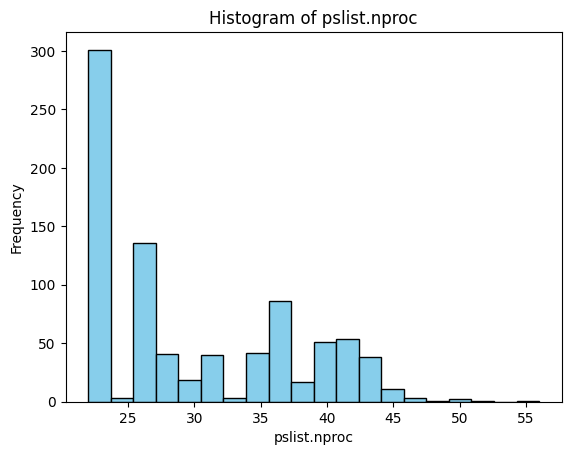


Feature: pslist.nproc, Mean: 30.023529411764706, Variance: 60.541259613386224


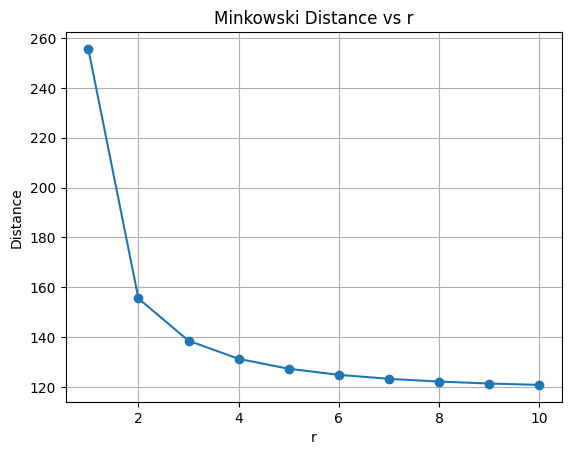


Minkowski Distances (r=1 to 10): [np.float64(255.6390607317993), 155.4695101859898, np.float64(138.50650314680735), np.float64(131.23396463617593), np.float64(127.25668926061822), np.float64(124.81662277464935), np.float64(123.21383799781913), np.float64(122.11281302261659), np.float64(121.33255390712156), np.float64(120.76699117944767)]

Test Accuracy (k=3): 0.48

Predictions (first 10): [0 0 1 0 1 0 1 1 0 0]
Prediction for first test vector: [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


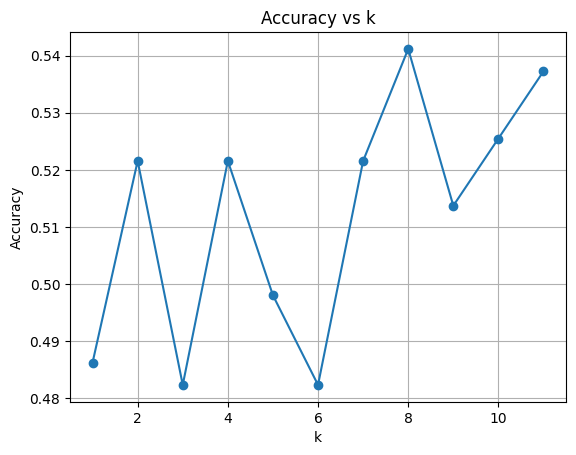


Accuracies for k=1 to 11: [0.48627450980392156, 0.5215686274509804, 0.4823529411764706, 0.5215686274509804, 0.4980392156862745, 0.4823529411764706, 0.5215686274509804, 0.5411764705882353, 0.5137254901960784, 0.5254901960784314, 0.5372549019607843]

Confusion Matrix:
 [[69 63]
 [69 54]]
Precision: 0.46, Recall: 0.44, F1 Score: 0.45
Train Accuracy: 0.78, Test Accuracy: 0.48
Model Status: Overfitting


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from scipy.spatial import distance

# ---------------------------
# Load and preprocess dataset
# ---------------------------
def load_dataset(csv_file):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=["Filename"], errors='ignore')
    df = df.loc[:, df.nunique() > 1]  # Drop constant features

    # Ensure only two classes are used (Spyware & Benign)
    if 'Class' not in df.columns:
        np.random.seed(42)
        df['Class'] = np.random.choice(['Spyware', 'Benign'], size=len(df))
    df = df[df['Class'].isin(['Spyware', 'Benign'])]

    X = df.drop(columns=['Class'])
    y = df['Class'].astype('category').cat.codes  # Convert to numeric
    return X, y, df['Class']

# ---------------------------
# A1: Intraclass spread & Interclass distance
# ---------------------------
def calculate_spread_and_distance(X, y_labels):
    classes = y_labels.unique()
    centroids = {}
    spreads = {}

    for cls in classes:
        class_vectors = X[y_labels == cls]
        centroids[cls] = class_vectors.mean(axis=0)
        spreads[cls] = class_vectors.std(axis=0)

    interclass_distance = np.linalg.norm(centroids[classes[0]] - centroids[classes[1]])
    return spreads, interclass_distance

# ---------------------------
# A2: Feature histogram, mean & variance
# ---------------------------
def feature_histogram_stats(X, feature_index=0):
    feature_name = X.columns[feature_index]
    feature_data = X[feature_name]

    plt.hist(feature_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()

    return feature_name, feature_data.mean(), feature_data.var()

# ---------------------------
# A3: Minkowski distance
# ---------------------------
def minkowski_distance_plot(X):
    vec1 = X.iloc[0]
    vec2 = X.iloc[1]
    r_values = range(1, 11)
    distances = [distance.minkowski(vec1, vec2, r) for r in r_values]

    plt.plot(r_values, distances, marker='o')
    plt.title("Minkowski Distance vs r")
    plt.xlabel("r")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()

    return distances

# ---------------------------
# A4: Train-test split
# ---------------------------
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# A5 & A6: Train & evaluate kNN (k=3)
# ---------------------------
def train_evaluate_knn(X_train, y_train, X_test, y_test, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    return knn, accuracy

# ---------------------------
# A7: Predict test vectors
# ---------------------------
def predict_test_samples(knn, X_test):
    return knn.predict(X_test), knn.predict([X_test.iloc[0]])

# ---------------------------
# A8: Accuracy vs k plot
# ---------------------------
def plot_accuracy_vs_k(X_train, y_train, X_test, y_test):
    k_values = range(1, 12)
    accuracies = []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        accuracies.append(model.score(X_test, y_test))

    plt.plot(k_values, accuracies, marker='o')
    plt.title("Accuracy vs k")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies

# ---------------------------
# A9: Confusion matrix & metrics
# ---------------------------
def evaluate_model(knn, X_test, y_test):
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    # Determine fit type
    if train_acc > test_acc + 0.1:
        fit_status = "Overfitting"
    elif abs(train_acc - test_acc) < 0.05:
        fit_status = "Regular fitting"
    else:
        fit_status = "Underfitting"

    return cm, precision, recall, f1, train_acc, test_acc, fit_status

# ---------------------------
# Main Program
# ---------------------------
if __name__ == "__main__":
    # Load dataset
    X, y, y_labels = load_dataset("Combined_MalMem.csv")

    # A1
    spreads, interclass_distance = calculate_spread_and_distance(X, y_labels)
    print("Class Spreads:\n", spreads)
    print("\nInterclass Distance:", interclass_distance)

    # A2
    feature_name, mean_feature, var_feature = feature_histogram_stats(X)
    print(f"\nFeature: {feature_name}, Mean: {mean_feature}, Variance: {var_feature}")

    # A3
    minkowski_distances = minkowski_distance_plot(X)
    print("\nMinkowski Distances (r=1 to 10):", minkowski_distances)

    # A4
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # A5 & A6
    knn, test_accuracy = train_evaluate_knn(X_train, y_train, X_test, y_test)
    print(f"\nTest Accuracy (k=3): {test_accuracy:.2f}")

    # A7
    predictions, single_prediction = predict_test_samples(knn, X_test)
    print("\nPredictions (first 10):", predictions[:10])
    print("Prediction for first test vector:", single_prediction)

    # A8
    accuracies = plot_accuracy_vs_k(X_train, y_train, X_test, y_test)
    print("\nAccuracies for k=1 to 11:", accuracies)

    # A9
    cm, precision, recall, f1, train_acc, test_acc, fit_status = evaluate_model(knn, X_test, y_test)
    print("\nConfusion Matrix:\n", cm)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
    print(f"Model Status: {fit_status}")


Class Spreads:
 {'Benign': pslist.nproc                              4.673019e+00
pslist.nppid                              2.422646e+00
pslist.avg_threads                        9.686393e-01
pslist.avg_handlers                       1.893978e+01
dlllist.ndlls                             2.134939e+02
dlllist.avg_dlls_per_proc                 2.711415e+00
handles.nhandles                          1.171207e+03
handles.avg_handles_per_proc              1.746406e+01
handles.nfile                             1.316389e+02
handles.nevent                            4.655067e+02
handles.ndesktop                          4.894856e+00
handles.nkey                              1.157430e+02
handles.nthread                           1.419302e+02
handles.ndirectory                        8.803291e+00
handles.nsemaphore                        5.441736e+01
handles.ntimer                            8.060817e+00
handles.nsection                          6.452967e+01
handles.nmutant                       

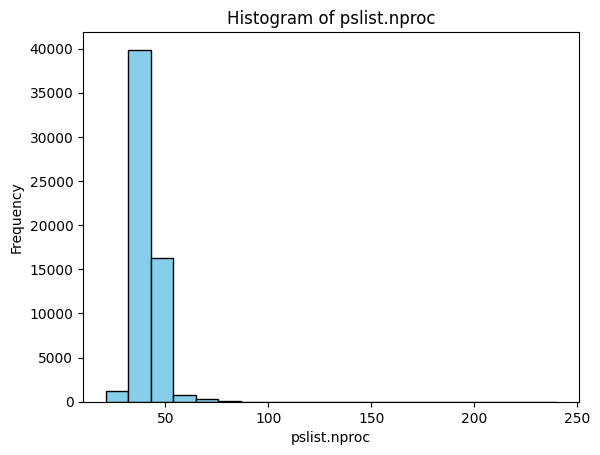


Feature: pslist.nproc, Mean: 41.39477097412793, Variance: 33.376604792668516


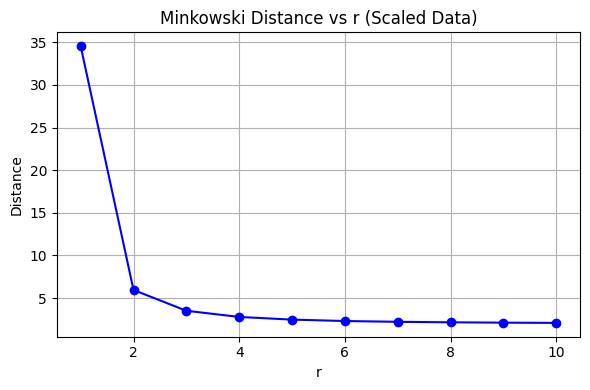


Minkowski Distances (r=1 to 10): [34.5416, 5.9429, 3.502, 2.7777, 2.4641, 2.3012, 2.2069, 2.1479, 2.1087, 2.0814]

Test Accuracy (k=3): 1.00

Predictions (first 10): [1 0 1 0 1 0 0 1 1 0]
Prediction for first test vector: [1]


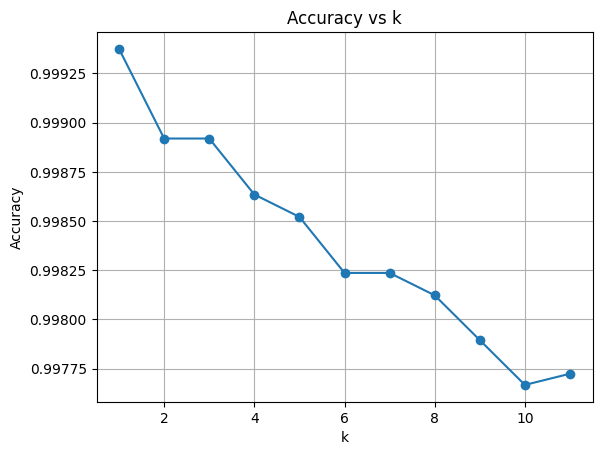


Accuracies for k=1 to 11: [0.9993742533704989, 0.9989191649126798, 0.9989191649126798, 0.9986347346265431, 0.9985209625120883, 0.9982365322259514, 0.9982365322259514, 0.9981227601114967, 0.9978952158825872, 0.9976676716536776, 0.9977245577109051]

Confusion Matrix:
 [[8744    6]
 [  13 8816]]
Precision: 0.999320, Recall: 0.998528, F1: 0.998924
Train Accuracy: 0.999659, Test Accuracy: 0.998919
Model Status: Regular fitting


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy.spatial import distance

# ---------------------------
# Load and preprocess dataset
# ---------------------------
def load_dataset(csv_file):
    df = pd.read_csv(csv_file)

    # Combine all malware types into one class: 'Malware'
    malware_classes = ['Trojan', 'Spyware', 'Ransomware', 'Worm', 'Adware', 'Rootkit']
    df['Class'] = df['Class'].replace(malware_classes, 'Malware')

    # Filter for binary classification
    df = df[df['Class'].isin(['Malware', 'Benign'])]

    # Drop unused columns
    df = df.drop(columns=["Filename", "Category"], errors='ignore')

    # Drop constant columns
    df = df.loc[:, df.nunique() > 1]

    # Prepare features and labels
    X = df.drop(columns=['Class'])
    y = df['Class'].astype('category').cat.codes  # Malware=1, Benign=0
    y_labels = df['Class']
    return X, y, y_labels

# ---------------------------
# A1: Intraclass spread & Interclass distance
# ---------------------------
def calculate_spread_and_distance(X, y_labels):
    classes = y_labels.unique()
    centroids = {}
    spreads = {}

    for cls in classes:
        class_vectors = X[y_labels == cls]
        centroids[cls] = class_vectors.mean(axis=0)
        spreads[cls] = class_vectors.std(axis=0)

    interclass_distance = np.linalg.norm(centroids[classes[0]] - centroids[classes[1]])
    return spreads, interclass_distance

# ---------------------------
# A2: Feature histogram, mean & variance
# ---------------------------
def feature_histogram_stats(X, feature_index=0):
    feature_name = X.columns[feature_index]
    feature_data = X[feature_name]

    plt.hist(feature_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()

    return feature_name, feature_data.mean(), feature_data.var()

def minkowski_distance_plot(X):
    from scipy.spatial.distance import minkowski
    from sklearn.preprocessing import StandardScaler

    # Scale the feature vectors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    vec1 = X_scaled[0]
    vec2 = X_scaled[1]

    r_values = range(1, 11)
    distances = []

    for r in r_values:
        dist = minkowski(vec1, vec2, p=r)
        distances.append(round(dist, 4))  # Rounded for readability

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(r_values, distances, marker='o', color='blue')
    plt.title("Minkowski Distance vs r (Scaled Data)")
    plt.xlabel("r")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return [float(round(d, 4)) for d in distances]



# ---------------------------
# A4: Train-test split
# ---------------------------
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------
# A5 & A6: Train & evaluate kNN (k=3)
# ---------------------------
def train_evaluate_knn(X_train, y_train, X_test, y_test, k=3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    return knn, accuracy

# ---------------------------
# A7: Predict test vectors
# ---------------------------
def predict_test_samples(knn, X_test):
    return knn.predict(X_test), knn.predict(X_test.iloc[[0]])


# ---------------------------
# A8: Accuracy vs k plot
# ---------------------------
def plot_accuracy_vs_k(X_train, y_train, X_test, y_test):
    k_values = range(1, 12)
    accuracies = []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        accuracies.append(model.score(X_test, y_test))

    plt.plot(k_values, accuracies, marker='o')
    plt.title("Accuracy vs k")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies

# ---------------------------
# A9: Confusion matrix & metrics
# ---------------------------
def evaluate_model(knn, X_train, y_train, X_test, y_test):
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    # Determine fit type
    if train_acc > test_acc + 0.1:
        fit_status = "Overfitting"
    elif abs(train_acc - test_acc) < 0.05:
        fit_status = "Regular fitting"
    else:
        fit_status = "Underfitting"

    return cm, precision, recall, f1, train_acc, test_acc, fit_status

# ---------------------------
# Main Program
# ---------------------------
if __name__ == "__main__":
    # Load dataset
    X, y, y_labels = load_dataset("/content/drive/MyDrive/Obfuscated-MalMem2022.csv")

    # A1
    spreads, interclass_distance = calculate_spread_and_distance(X, y_labels)
    print("Class Spreads:\n", spreads)
    print("\nInterclass Distance:", interclass_distance)

    # A2
    feature_name, mean_feature, var_feature = feature_histogram_stats(X)
    print(f"\nFeature: {feature_name}, Mean: {mean_feature}, Variance: {var_feature}")

    # A3
    minkowski_distances = minkowski_distance_plot(X)
    print("\nMinkowski Distances (r=1 to 10):", minkowski_distances)

    # A4
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # A5 & A6
    knn, test_accuracy = train_evaluate_knn(X_train, y_train, X_test, y_test)
    print(f"\nTest Accuracy (k=3): {test_accuracy:.2f}")

    # A7
    predictions, single_prediction = predict_test_samples(knn, X_test)
    print("\nPredictions (first 10):", predictions[:10])
    print("Prediction for first test vector:", single_prediction)

    # A8
    accuracies = plot_accuracy_vs_k(X_train, y_train, X_test, y_test)
    print("\nAccuracies for k=1 to 11:", accuracies)

    # A9
    cm, precision, recall, f1, train_acc, test_acc, fit_status = evaluate_model(knn, X_train, y_train, X_test, y_test)
    print("\nConfusion Matrix:\n", cm)
    print(f"Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}")
    print(f"Train Accuracy: {train_acc:.6f}, Test Accuracy: {test_acc:.6f}")
    print(f"Model Status: {fit_status}")


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Convert to float arrays
y_true = y_test.values.astype(np.float64)
y_pred = predictions.astype(np.float64)

# Mask: ignore entries where y_true == 0
mask = y_true != 0
y_true_masked = y_true[mask]
y_pred_masked = y_pred[mask]

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE (no zero true values): {mape:.6f}%")
print(f"R²: {r2:.3f}")


MSE: 0.001081
RMSE: 0.032876
MAPE (no zero true values): 0.147242%
R²: 0.996
